<h4 style = "color:red"> 
    The initial part of this notebook contains the code for FFT, DST, and the Model Problem. <br>
    The solutions to the Homework 3.4 and 3.5 are further below
</h4>


In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Fast Fourier Transform

In [2]:
# 1D Fast Fourier Transform
def FastFourier1(x:np.ndarray):
    N = x.shape[0]
    if N == 1: return x # base case of recursive algoritm
    if N%2 != 0: raise ValueError(f"N = {N} must be of size 2^m")

    X_even = FastFourier1(x[0::2])
    X_odd = FastFourier1(x[1::2])

    factor = np.exp(-1j * 2 * np.pi * np.arange(N)/N)
    
    mid = N//2
    p1 = X_even + factor[:mid] * X_odd
    p2 = X_even + factor[mid:] * X_odd

    return np.concatenate([p1,p2])

In [3]:
# 2D Fast Fourier Transform
def FastFourier2(x):
    """
    2D FFT computed using 1D FFT on rows then columns.
    Input must be a square array with power-of-two side length.
    """
    x = np.asarray(x, dtype=complex)
    N, M = x.shape

    if N != M:
        raise ValueError("Only square matrices supported for simplicity")
    if N%2 != 0:
        raise ValueError("Matrix dimensions must be powers of 2")

    # FFT along rows
    X = np.zeros_like(x, dtype=complex)
    for i in range(N):
        X[i, :] = FastFourier1(x[i, :])

    # FFT along columns
    X_final = np.zeros_like(X, dtype=complex)
    for j in range(M):
        X_final[:, j] = FastFourier1(X[:, j])

    return X_final


## Fast Discrete Sine Transform

In [4]:
# 1D fast Sine transform
def FastSine1(f:np.ndarray):
    # f is an array of size N 
    N = f.shape[0] # f is all points

    # Build odd extension of length 2N
    g = np.zeros(2*N, dtype=complex)
    g[:N] = f[:] # first N-1 values from 1,2,...N-1 
    g[N+1:] = -g[N-1:0:-1] # last N-1 values 

    # Compute FFT of odd-extension
    gk = FastFourier1(g)

    return -gk.imag[:N]


In [5]:
# 2D Fast Sine transform
def FastSine2(f):
    N, M = f.shape
    if N != M: raise ValueError("Grid must be square")

    # transform rows
    temp = np.zeros_like(f, dtype=float)
    for i in range(N):
        temp[i, :] = FastSine1(f[i, :])

    # transform columns
    dstMat = np.zeros_like(f, dtype=float)
    for j in range(M):
        dstMat[:, j] = FastSine1(temp[:, j])

    return dstMat


## Model Problem

In [6]:
# Analytical solution u(x,y) = x(x-1)(x-1)y(y-1)
def AnalyticalSolution(N, dbc = True):
    """ Evaluates the analytical solution u(x,y) on a grid with Dirichlet Boundary Conditions""" 
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    X, Y = np.meshgrid(x, y, indexing='ij')
    U = X*(X-1)*(X-1)*(Y)*(Y-1)
    if dbc:
        U[[0, -1], :] = U[:, [0, -1]] = 0 # apply Dirichlet boundary 
    return U

In [7]:
# Analytical laplacian f(x,y) = -(6x-4)y(y-1) - 2(x)(x-1)(x-1)
def AnalyticalLaplacian(N, dbc = True):
    """ Evaluates the analytical laplacian f(x,y) on a grid with Dirichlet Boundary Conditions""" 
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    X, Y = np.meshgrid(x, y, indexing='ij')
    t1 = (6*X - 4)*(Y)*(Y - 1) 
    t2 = 2*(X)*(X - 1)*(X - 1)
    F = -(t1+t2)
    if dbc:
        F[[0, -1], :] = F[:, [0, -1]] = 0 # apply Dirichlet boundary 
    return F

## Metrics of error & convergence

In [8]:
# Error-Norm, Average-Rate-Of-Convergence
# dont include U[0][j], U[-1][j], U[i][0], U[i][-1] in the evaluation 
# of residuals and error-norm because those are boundary values

def ErrorNorm(Uk, U):
    """ 
    Compute Error norm given the kth iteration of solution and the analytical solution 
    Uk : kth iteration of U
    LAP : Analytical solution 
    returns error norm at kth iteration
    """
    
    N = Uk.shape[0]
    h = 1.0 / (N - 1)
    
    # Compute the error (excluding boundaries)
    err = U[1:-1, 1:-1] - Uk[1:-1, 1:-1]
    
    # Compute the error norm
    norm = np.sqrt(np.sum((err * h)**2))
    
    return norm

# Compute Average Rate of Convergence given Error-Norm[k]
def AverageROC(Ek,E0,k):
    """ 
    Compute Average rate of convergence given the kth iteration of error 
    Ek : error at kth iteration
    E0 : error at 0th iteration
    k  : iteration number
    returns average rate of convergence at kth iteration
    """
    
    if Ek <= 0 or E0 <= 0 or k == 0: 
        return 0.0
    aroc = -np.log(Ek/E0)/k
    return aroc

## Solution to the model-problem as a Fourier series expansion 
_NOTE: Since we're applying Dirichlet Boundary conditions to the model problem, the Fourier transform is actually the Sine transform_ <br> 
The solution $u_{ij}$ is given by the Inverse Fourier Transform of the Laplacian's Fourier coefficients. 
$$ 
u_{i,j} = \sum_{m=1}^{N} \sum_{n=1}^{N} \frac{\hat{f}_{m,n}}{\lambda_{m,n}} \sin(m \pi x_i ) \sin(n \pi y_j)
$$ 
where $\lambda_{m,n}$ is given by
$$ \lambda_{m,n} = 4N^2 \left( \sin^2 \frac{m \pi}{2N} + \sin^2 \frac{n \pi}{2N}\right)$$ 

and $\hat{f}_{m,n}$ are the coefficients of the Fourier expansion of the laplacian $f_{ij}$

$$ \hat{f}_{m,n} = \left( \frac{2}{N}\right)^2 \sum_{i=1}^{N-1} \sum_{j=1}^{N-1} f_{i,j} \sin(m\pi x_i) \sin(n\pi y_j)$$ 


### $\lambda_{mn}$ matrix function

In [9]:
# Evaluate the lambda_mn matrix for a given N
def Lambda_mn(N):
    
    h = 1.0/N
    idx = np.arange(1, N-1)
    m = idx
    n = idx
    # lambda_mn for the allowed modes
    lambda_m = 4 * N * N * (np.sin(0.5 * m * np.pi * h)**2)
    lambda_n = 4 * N * N * (np.sin(0.5 * n * np.pi * h)**2)
    lambda_mn = lambda_m[:, None] + lambda_n[None, :]   # (N-2, N-2)

    lambda_mn = np.pad(lambda_mn, pad_width=((1, 1), (1, 1)), mode='constant', constant_values=1) # pad it with ONEs so that we dont get the annoying divide by zero warnings

    return lambda_mn
    

### $u_{ij}$ matrix function

In [10]:
# Evaluate the solution u_ij given the Laplacian f_ij
def Uij_DST(fij):
    N = fij.shape[0]
    h = 1.0/N
    fhat_mn = FastSine2(fij)
    lambda_mn = Lambda_mn(N)
    uhat_mn = fhat_mn/lambda_mn
    uhat_mn[[0, -1], :] = uhat_mn[:, [0, -1]] = 0 # apply Dirichlet boundary 
    u = FastSine2(uhat_mn)

    norm = (0.5/N)**2

    return u*norm
    

<br>

---------------------------------------------

<br>

<h2 style = "color:red"> Homework 3.4 </h2>
Solve the 2D model problem using Discrete Sine Transform for N = 16, 32, 64

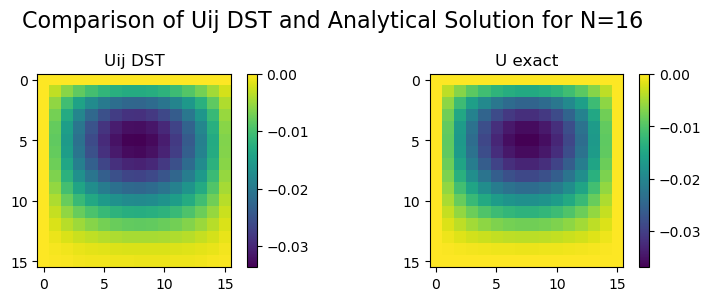

In [11]:
# Solve Model Problem for N = 16
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot each matrix
im0 = axes[0].imshow(Uij_DST(AnalyticalLaplacian(16)), cmap='viridis')
axes[0].set_title('Uij DST')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(AnalyticalSolution(16), cmap='viridis')
axes[1].set_title('U exact')
plt.colorbar(im1, ax=axes[1])

# Add title for the entire figure
plt.suptitle('Comparison of Uij DST and Analytical Solution for N=16', fontsize=16)

plt.tight_layout()
plt.show()

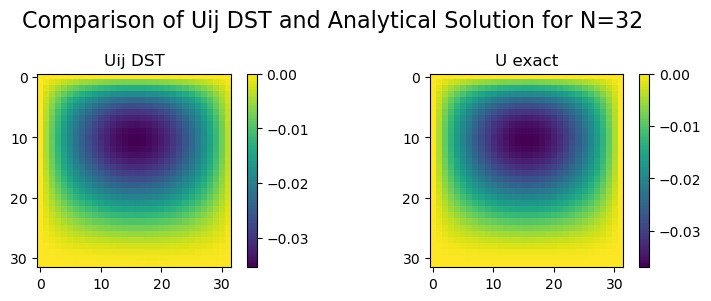

In [12]:
# Solve Model Problem for N = 32
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot each matrix
im0 = axes[0].imshow(Uij_DST(AnalyticalLaplacian(32)), cmap='viridis')
axes[0].set_title('Uij DST')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(AnalyticalSolution(32), cmap='viridis')
axes[1].set_title('U exact')
plt.colorbar(im1, ax=axes[1])

# Add title for the entire figure
plt.suptitle('Comparison of Uij DST and Analytical Solution for N=32', fontsize=16)

plt.tight_layout()
plt.show()


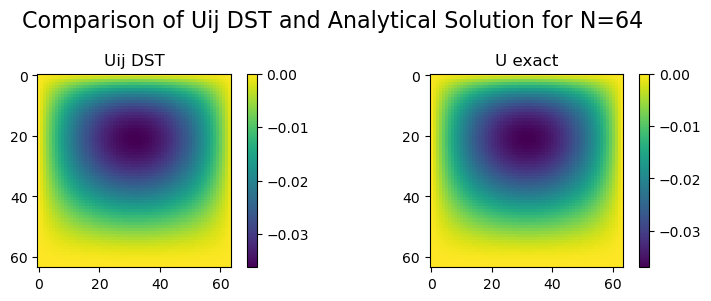

In [13]:
# Solve Model Problem for N = 64
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot each matrix
im0 = axes[0].imshow(Uij_DST(AnalyticalLaplacian(64)), cmap='viridis')
axes[0].set_title('Uij DST')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(AnalyticalSolution(64), cmap='viridis')
axes[1].set_title('U exact')
plt.colorbar(im1, ax=axes[1])

# Add title for the entire figure
plt.suptitle('Comparison of Uij DST and Analytical Solution for N=64', fontsize=16)

plt.tight_layout()
plt.show()



<br>

---------------------------------------------

<br>

<h2 style = "color:red"> Homework 3.5 </h2>

Consider the variable coefficient elliptic partial differential equation
\begin{equation}
-\nabla \cdot a(x, y) \nabla u = f, \quad (x, y) \in \Omega, \quad u(x, y) = 0, \quad (x, y) \in \partial \Omega
\end{equation}
where
\begin{equation}
a(x, y) = 1 + 0.2 \sin 2\pi x + 0.2 \sin 2\pi y
\end{equation}
and consider its finite difference approximation.
$$ 
\frac{a_{i+1/2,j} (u_{i+1,j} - u_{i,j}) - a_{i-1/2,j} (u_{i,j} - u_{i-1,j})}{h^2}
- \frac{a_{i,j+1/2} (u_{i,j+1} - u_{i,j}) - a_{i,j-1/2} (u_{i,j} - u_{i,j-1})}{h^2}
= f_{i,j}
$$ 

Solve the variable-coefficient PDE problem using the following iterative procedure 

$$ P(u^{(k+1)} - u^{(k)}) = f - Au^{(k)} $$

where $A$ is the finite-difference operator and $P$ is the discrete Laplacian solved by the FFT. 
Solve for N = 16, 32, 64

<h4 style = "color:red"> Answer 3.5 </h4>
<details>
    
$$ P(u^{(k+1)} - u^{(k)}) = f - Au^{(k)} $$
$$ \Rightarrow u^{(k+1)} = u^{(k)} + P^{-1}(f - Au^{(k)}) $$
$$ f - A u^k = r^k \text{ residue}$$ 
we need to find $w^k$ such that $Pw = r^k$ <br>
$w^k$ can be obtained by the inverse sine transform of $\hat{r}^k_{mn}$ where $\hat{r}^k_{mn}$ are the coefficients of the fourier expansion of the residue $r^k$
$$ w^k_{ij} = \sum_{m,n=1}^{N-1} \frac{\hat{r}^k_{m,n}}{\lambda_{m,n}} \sin(m \pi x_i) \sin(n \pi y_j)$$ 

where 
$$ \hat{r}^k_{m,n} = \left( \frac{2}{N}\right)^2 \sum_{i=1}^{N-1} \sum_{j=1}^{N-1} r^k_{i,j} \sin(m\pi x_i) \sin(n\pi y_j)$$ 

and 
$$ \lambda_{m,n} = 4N^2 \left( \sin^2 \frac{m \pi}{2N} + \sin^2 \frac{n \pi}{2N}\right)$$ 

$r^k_{ij}$ can be evaluated from $f - Au^k$ at each iteration. $f$ can be analytically approximated as $Au$ where $u$ is the exact solution to the 2D model problem with constant coefficients i.e $u(x, y) = x(x − 1)^2y(y − 1)$
</details>

In [14]:
def VariableCoefficient(x,y):
    return 1 + 0.2 * np.sin(2*np.pi*x) + 0.2 * np.sin(2*np.pi*y )

In [15]:
# Apply the Finite-Difference approximation operator A to a solution u_ij
def ApplyOperatorA(U:np.ndarray):
    N = U.shape[0]
    h = 1.0/(N)
    F = np.zeros_like(U,dtype='float')

    for i in range(1,N-1):
        for j in range(1,N-1):
            a_right = VariableCoefficient( (i+0.5)*h, j*h )
            a_left = VariableCoefficient( (i-0.5)*h, j*h )
            a_up = VariableCoefficient( i*h, (j-0.5)*h)
            a_down = VariableCoefficient( i*h, (j+0.5)*h)
            
            u_left = U[i-1][j]
            u_right = U[i+1][j]
            u_up = U[i][j-1]
            u_down = U[i][j+1]
            u_center =U[i][j]

            t1 = a_right*(u_right - u_center) - a_left * (u_center - u_left)
            t2 = a_down*(u_down - u_center) - a_up * (u_center - u_up)

            F[i][j] = t1 + t2
            
    return -F/(h**2)

In [16]:
# Solve the variable coefficient PDE problem for a given N
def SolveVariableCoeffPDE(N:int,max_iter = 120):
    U = AnalyticalSolution(N)
    F = ApplyOperatorA(U)
    uk = np.zeros((N,N),dtype='float') # initial guess
    E0 = ErrorNorm(U,uk) # 0th iteration of error-norm

    err_arr = []  # error-norm 
    aroc_arr = [] # average rate of convergence 

    for k in range(max_iter):
        Auk = ApplyOperatorA(uk)
        rk = F - Auk # residue
        wk = Uij_DST(rk)

        # Evaluate metrics for error and convergence
        Ek = ErrorNorm(U,uk) # error norm
        arock = AverageROC(Ek, E0, k)
        err_arr.append(Ek)
        aroc_arr.append(arock)

        # update the current iteration
        uk += wk
        
    return {
        "uk" : uk, 
        "err":np.array(err_arr), 
        "aroc": np.array(aroc_arr)
    }

### Solve the variable coefficient PDE for $N = 16, 32, 64$ 

In [17]:
variableSolution_16 = SolveVariableCoeffPDE(16)

In [18]:
variableSolution_32 = SolveVariableCoeffPDE(32)

In [19]:
variableSolution_64 = SolveVariableCoeffPDE(64)

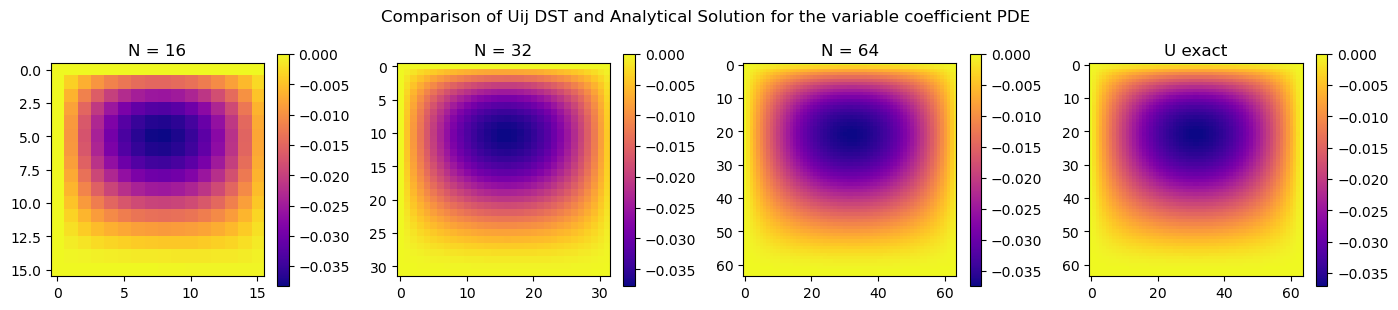

In [28]:
# plot the final solutions 
fig, axes = plt.subplots(1, 4, figsize=(14, 3))

# Plot each matrix
im0 = axes[0].imshow(variableSolution_16["uk"], cmap='plasma')
axes[0].set_title('N = 16')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(variableSolution_32["uk"], cmap='plasma')
axes[1].set_title('N = 32')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(variableSolution_64["uk"], cmap='plasma')
axes[2].set_title('N = 64')
plt.colorbar(im2, ax=axes[2])

im3 = axes[3].imshow(AnalyticalSolution(64), cmap='plasma')
axes[3].set_title('U exact')
plt.colorbar(im3, ax=axes[3])

# Add title for the entire figure
plt.suptitle('Comparison of Uij DST and Analytical Solution for the variable coefficient PDE ', fontsize=12)

plt.tight_layout()
plt.show()


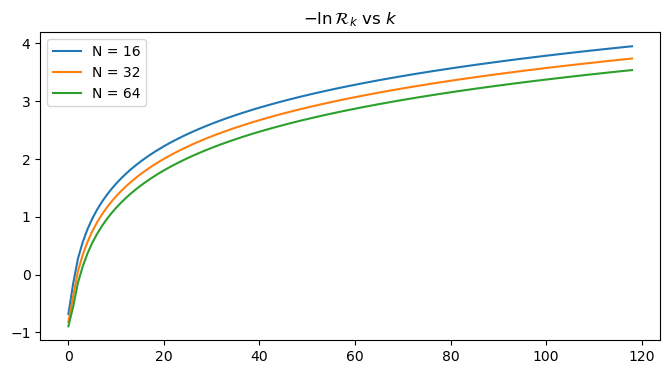

In [77]:
plt.figure(figsize=(8,4))
plt.plot(-np.log(variableSolution_16["aroc"][1:]),label = 'N = 16')
plt.plot(-np.log(variableSolution_32["aroc"][1:]),label = 'N = 32')
plt.plot(-np.log(variableSolution_64["aroc"][1:]),label = 'N = 64')
plt.legend()
plt.title("$-\\ln \\mathcal{R}_k$ vs $k$")
plt.show()

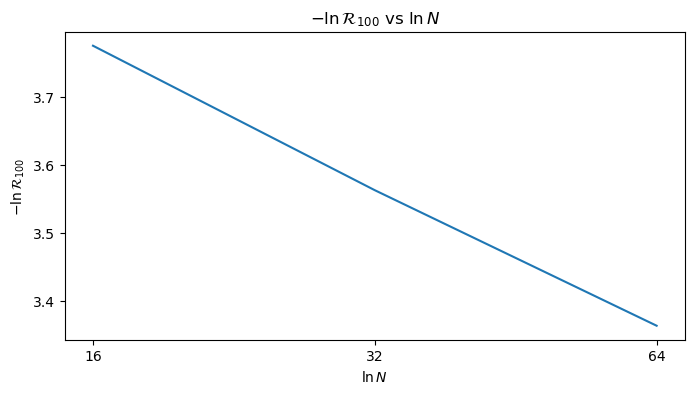

In [75]:
plt.figure(figsize=(8,4))
k = 100
x = np.log(np.array([16,32,64]))
y = -np.log(np.array([variableSolution_16["aroc"][k],variableSolution_32["aroc"][k], variableSolution_64["aroc"][k]]))

plt.ylabel("$-\\ln \\mathcal{R}_{100}$")
plt.xlabel("$\\ln N$")
plt.xticks(x,["16","32", "64"])

plt.title("$ -\\ln \\mathcal{R}_{100} $ vs $\\ln N$")
plt.plot(x,y)
plt.show()

## $\mathcal{R}_{100}$ is linearly dependent on grid size